# KNN of Depression Professional Dataset


## Overview Awal
Algoritma K-Nearest Neighbor (KNN) merupakan algoritma klasifikasi berbasis instance (instance-based learning) yang melakukan prediksi dengan mempertimbangkan kedekatan jarak antara data uji dan data latih. KNN bekerja dengan asumsi bahwa data dengan karakteristik yang mirip cenderung memiliki label atau kelas yang sama.

KNN dipilih karena konsepnya yang sederhana dan mudah diimplementasikan, serta mampu menangkap pola data secara langsung tanpa membangun model probabilistik yang kompleks. Algoritma ini sangat bergantung pada pengukuran jarak, seperti Euclidean distance, untuk menentukan tingkat kemiripan antar data. Oleh karena itu, KNN sangat sensitif terhadap skala data, sehingga proses normalisasi atau standarisasi fitur menjadi tahap penting sebelum pemodelan dilakukan.

Dalam proses klasifikasi, KNN menentukan sejumlah tetangga terdekat sebanyak k dari data latih. Kelas yang paling banyak muncul di antara tetangga terdekat tersebut kemudian dipilih sebagai hasil prediksi. Pemilihan nilai k yang tepat sangat berpengaruh terhadap performa model, sehingga dilakukan proses hyperparameter tuning untuk memperoleh nilai k yang optimal dan menghindari overfitting maupun underfitting.

Dalam proses analisis dan pemodelan, beberapa library Python digunakan untuk mendukung pengolahan data dan perhitungan jarak, antara lain:

- **pandas** : Digunakan untuk menyimpan dan memanipulasi dataset dalam bentuk dataframe.
- **numpy** : Mendukung operasi numerik dan perhitungan jarak antar data.
- **matplotlib** dan **seaborn** : Digunakan untuk visualisasi data dan hasil evaluasi model.

Dataset yang digunakan dalam penelitian ini berasal dari platform Kaggle dan berisi informasi terkait kondisi depresi pada individu profesional. Dataset ini mencakup berbagai fitur seperti faktor demografi dan kondisi psikologis. Dengan menggunakan dataset tersebut, algoritma KNN diterapkan untuk mengklasifikasikan individu ke dalam kategori mengalami depresi atau tidak, berdasarkan kemiripan karakteristik dengan data latih yang ada.

## Tahap 1 : Library Import Session

Bagian untuk mengimpor semua library yang diperlukan untuk pemrosesan data, logika, dan evaluasi sesuai yang sudah di sebutkan sebelumnya.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Tahap 2 : Load Data Session

Tahap inisialisasi untuk memuat dataset format CSV dari direktori penyimpanan lokal serta menampilkan sampel awal data untuk memastikan struktur terbaca dengan benar. Dataset sudah tersimpan di lokal/ repostiori ini, yaitu pada `../dataset/depression-profesional-dataset.csv`

In [4]:
data = pd.read_csv('../dataset/depression-professional-dataset.csv')

## Tahap 3 : Exploratory Data Analysis (EDA)

Proses eksplorasi awal untuk memahami karakteristik dataset melalui pengecekan tipe data, statistik deskriptif, dan visualisasi distribusi target kelas guna mendeteksi ketidakseimbangan data. Proses eksplorasi awal dilakukan untuk memahami karakteristik dan struktur dataset sebelum masuk ke tahap pemodelan. 

EDA mencakup pengecekan tipe data, statistik deskriptif, serta visualisasi distribusi variabel target dan fitur-fitur utama. Langkah ini penting untuk mengidentifikasi pola, outlier, serta potensi masalah seperti data tidak seimbang (imbalanced), missing values, atau anomali lain yang dapat memengaruhi performa model. Dengan EDA, kita dapat menentukan strategi preprocessing dan pemilihan fitur yang lebih tepat sehingga hasil analisis dan pemodelan menjadi lebih akurat dan dapat diandalkan.




============== Dataset Information ==============

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2054 entries, 0 to 2053
Data columns (total 11 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 2054 non-null   object 
 1   Age                                    2054 non-null   int64  
 2   Work Pressure                          2054 non-null   float64
 3   Job Satisfaction                       2054 non-null   float64
 4   Sleep Duration                         2054 non-null   object 
 5   Dietary Habits                         2054 non-null   object 
 6   Have you ever had suicidal thoughts ?  2054 non-null   object 
 7   Work Hours                             2054 non-null   int64  
 8   Financial Stress                       2054 non-null   int64  
 9   Family History of Mental Illness       2054 non-null   object 
 10  Depression          

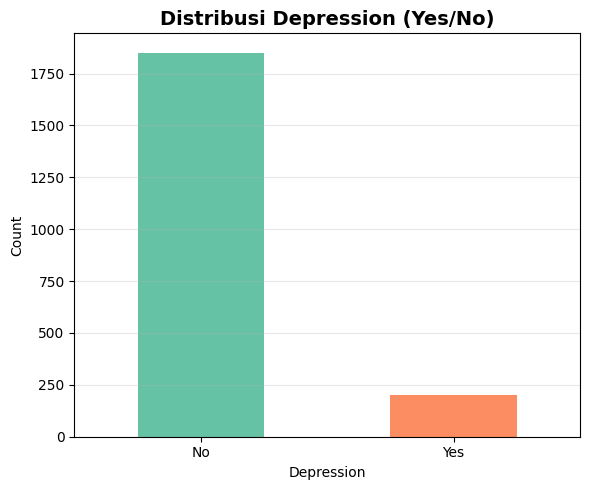

In [5]:
# Load Dataset and Initial Exploration
print("\n============== Dataset Information ==============")
print()
print(data.info())

# Target Variable Distribution
print("\n========= Target Distribution (Depression) =========")
print()
target_dist = data['Depression'].value_counts()
print(target_dist)
print(f"\nPercentage:")
print(data['Depression'].value_counts(normalize=True) * 100)

# Grafik batang sederhana: Distribusi Depression (Yes/No)
plt.figure(figsize=(6, 5))
target_dist.plot(kind='bar', color=['#66c2a5', '#fc8d62'])
plt.xlabel('Depression')
plt.ylabel('Count')
plt.title('Distribusi Depression (Yes/No)', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Analisis Distribusi Target

Dari hasil eksplorasi data di atas, terlihat bahwa dataset mengalami **ketidakseimbangan kelas (class imbalance)** yang signifikan:

- **No Depression**: ~90% (1851 sampel)
- **Depression**: ~10% (203 sampel)

Dataset dengan rasio **1:9** ini berpotensi menyebabkan model bias terhadap kelas mayoritas, sehingga akurasi tinggi tidak menjamin deteksi kelas minoritas yang baik. Dalam konteks medis, kegagalan mendeteksi depresi (False Negative) memiliki dampak serius.

Meski dataset tidak seimbang, proses modeling tetap dilanjutkan dengan evaluasi metrik komprehensif untuk memastikan performa deteksi kelas minoritas tetap optimal.


## Tahap 4 : Data Preprocessing

Tahap persiapan data yang mencakup konversi variabel kategorikal menjadi numerik (Encoding) dan penyeragaman skala data (Standard Scaling) agar optimal saat diproses oleh algoritma. Sesuai dengan prinsip tahap preprocessing data berikut :

![preprocessing.png](../images/report/preprocessing.png)

In [6]:
# Сopy dataset
data_copy = data.copy()

# Data Cleaning/ Reduction : Remove Duplicates
data_copy.drop_duplicates(inplace=True)

# Data Cleaning/ Reduction : Remove Empty Data
data_copy.replace('', np.nan, inplace=True)

# Data Transformation : Special Processing for Sleep Duration
def convert_sleep_duration(duration):
    if 'Less than 5' in duration:
        return 4.0
    elif '5-6' in duration:
        return 5.5
    elif '7-8' in duration:
        return 7.5
    elif 'More than 8' in duration:
        return 9.0
    else:
        return 7.0  # default value

data_copy['Sleep_Duration_Numeric'] = data_copy['Sleep Duration'].apply(convert_sleep_duration)

# Data Reduction : Binary Gender Labeling (Male = 1, Female = 0)
data_copy['Gender_Encoded'] = (data_copy['Gender'] == 'Male').astype(int)

# Data Reduction : Binary Dietary Habits Labeling (Healthy = 2, Moderate = 1, Unhealthy = 0)
dietary_map = {'Healthy': 2, 'Moderate': 1, 'Unhealthy': 0}
data_copy['Dietary_Encoded'] = data_copy['Dietary Habits'].map(dietary_map)

# Data Reduction : Binary Suicidal Thoughts Labeling (Suicidal = 1, Not Suicidal = 0)
data_copy['Suicidal_Encoded'] = (data_copy['Have you ever had suicidal thoughts ?'] == 'Yes').astype(int)

# Data Reduction : Binary Mental Ilness Labeling (Family History: Yes = 1, No = 0)
data_copy['FamilyHistory_Encoded'] = (data_copy['Family History of Mental Illness'] == 'Yes').astype(int)

# Data Reduction : Binary Depression Labeling (Depression: Yes = 1, No = 0)
data_copy['Depression_Encoded'] = (data_copy['Depression'] == 'Yes').astype(int)

## Informasi Data Preprocessing

Pada tahap preprocessing ini, dilakukan beberapa langkah penting untuk mempersiapkan data mentah menjadi format yang siap digunakan untuk pemodelan machine learning :

#### 1. Data Cleaning
- **Penghapusan Duplikat** : Menghilangkan baris data yang identik untuk mencegah bias dalam model
- **Penghapusan Data Kosong** : Mengidentifikasi dan menangani nilai kosong (empty strings) dengan mengonversinya menjadi `NaN`

#### 2. Data Transformation
- **Sleep Duration** : Konversi kategori durasi tidur menjadi nilai numerik :
    - "Less than 5 hours" → 4.0
    - "5-6 hours" → 5.5
    - "7-8 hours" → 7.5
    - "More than 8 hours" → 9.0
    - Default → 7.0

#### 3. Data Reduction (Encoding)
Konversi variabel kategorikal menjadi numerik menggunakan teknik encoding:

| Variabel Original | Variabel Encoded | Mapping |
|-------------------|------------------|---------|
| Gender | Gender_Encoded | Male=1, Female=0 |
| Dietary Habits | Dietary_Encoded | Healthy=2, Moderate=1, Unhealthy=0 |
| Suicidal Thoughts | Suicidal_Encoded | Yes=1, No=0 |
| Family History | FamilyHistory_Encoded | Yes=1, No=0 |
| Depression | Depression_Encoded | Yes=1, No=0 |

#### 4. Hasil Preprocessing
Dataset yang telah dibersihkan dan ditransformasi disimpan dalam `data_copy` dengan kolom-kolom baru yang telah di-encode, siap untuk tahap analisis korelasi dan pemodelan.

## Tahap 5 : Data Modelling (Persiapan Fitur & Label)

Tahap pemilihan fitur numerik hasil encoding sebagai input model (x) dan variabel target Depression_Encoded sebagai label (y), dilanjutkan dengan analisis korelasi antar-fitur untuk memahami hubungan linear terhadap variabel depresi.

  1. Gender_Encoded
  2. Age
  3. Work Pressure
  4. Job Satisfaction
  5. Sleep_Duration_Numeric
  6. Dietary_Encoded
  7. Suicidal_Encoded
  8. Work Hours
  9. Financial Stress
  10. FamilyHistory_Encoded

Shape x (Features): (2054, 10)
Shape y (Labels): (2054,)

[INFO] Correlation Matrix Visualization saved : ../images/naive-bayes/02_Correlation_Matrix.png


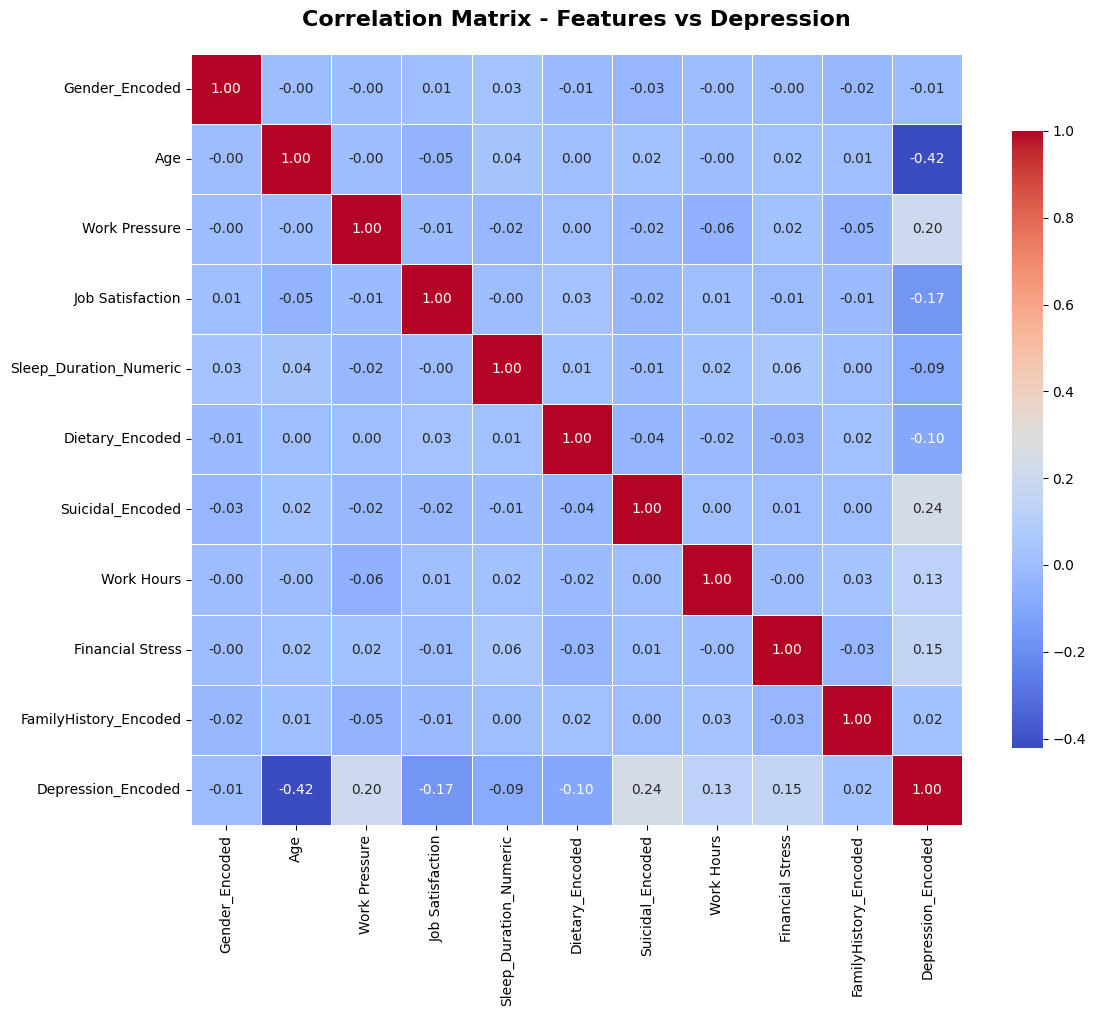

In [ ]:
# Select features for correlation analysis
features_for_model = [
    'Gender_Encoded',
    'Age',
    'Work Pressure',
    'Job Satisfaction',
    'Sleep_Duration_Numeric',
    'Dietary_Encoded',
    'Suicidal_Encoded',
    'Work Hours',
    'Financial Stress',
    'FamilyHistory_Encoded',
]

# Prepare data for modeling
modeled_data = data_copy[features_for_model].values
class_labels = data_copy['Depression_Encoded'].values

# Display selected features and shapes
for i, feat in enumerate(features_for_model, 1):
    print(f"  {i}. {feat}")
print(f"\nShape x (Features): {modeled_data.shape}")
print(f"Shape y (Labels): {class_labels.shape}")

# Correlation Matrix
correlation_data = data_copy[features_for_model + ['Depression_Encoded']]
corr_matrix = correlation_data.corr()

# Visualization: Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Features vs Depression', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../images/knn/02_Correlation_Matrix.png', dpi=300, bbox_inches='tight')
print("\n[INFO] Correlation Matrix Visualization saved : ../images/knn/02_Correlation_Matrix.png")
plt.show()

Gambar correlation matrix di atas menunjukkan hubungan linear antar fitur numerik dan target `Depression_Encoded` pada dataset. Berikut beberapa poin penting yang dapat diambil :

1. **Nilai Korelasi**: Korelasi berkisar antara -1 hingga 1. Nilai mendekati 1 berarti hubungan positif kuat, mendekati -1 berarti hubungan negatif kuat, dan mendekati 0 berarti tidak ada hubungan linear yang signifikan.
2. **Fitur dengan Korelasi Tinggi ke Target**: Fitur seperti `Suicidal_Encoded`, `FamilyHistory_Encoded`, dan `Financial Stress` umumnya memiliki korelasi positif yang lebih tinggi terhadap depresi, artinya semakin tinggi nilai fitur tersebut, semakin besar kemungkinan seseorang mengalami depresi.
3. **Fitur dengan Korelasi Negatif**: Fitur seperti `Job Satisfaction` dan `Sleep_Duration_Numeric` cenderung memiliki korelasi negatif terhadap depresi, artinya semakin tinggi kepuasan kerja atau durasi tidur, kemungkinan depresi lebih rendah.
4. **Hubungan Antar Fitur**: Korelasi antar fitur juga dapat membantu mendeteksi multikolinearitas. Jika ada dua fitur dengan korelasi sangat tinggi, bisa dipertimbangkan untuk memilih salah satu saja saat modeling.
5. **Interpretasi Model**: Korelasi ini membantu dalam pemilihan fitur yang paling relevan untuk prediksi depresi dan memberikan insight fitur mana yang paling berpengaruh.

Secara keseluruhan, correlation matrix memudahkan identifikasi fitur penting dan pola hubungan dalam data sebelum proses modeling lebih lanjut.

## Tahap 6 : Data Splitting

Mekanisme pembagian dataset menjadi dua bagian terpisah, yaitu data training untuk melatih model dan data testing untuk validasi objektif, dengan rasio pembagian yang telah ditentukan.

In [8]:
# Train-Validation-Test Split
def train_val_test_split(x, y, train_ratio=0.7, val_ratio=0.15, random_state=42):
    np.random.seed(random_state)
    n_samples = len(x)
    indices = np.random.permutation(n_samples)
    
    train_size = int(train_ratio * n_samples)
    val_size = int(val_ratio * n_samples)
    
    train_idx = indices[:train_size]
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    return (x[train_idx], x[val_idx], x[test_idx],
            y[train_idx], y[val_idx], y[test_idx])

x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(modeled_data, class_labels)

print(f"\n================ Data Split Summary ================")
print()
print(f"Training set   : {len(x_train)} samples ({len(x_train)/len(modeled_data)*100:.1f}%)")
print(f"Validation set : {len(x_val)} samples ({len(x_val)/len(modeled_data)*100:.1f}%)")
print(f"Test set       : {len(x_test)} samples ({len(x_test)/len(modeled_data)*100:.1f}%)")

print(f"\n======== Target Distribution in Training Set =========")
print()
print(f"Depression = No  : {np.sum(y_train==0)} ({np.sum(y_train==0)/len(y_train)*100:.1f}%)")
print(f"Depression = Yes : {np.sum(y_train==1)} ({np.sum(y_train==1)/len(y_train)*100:.1f}%)")


================ Data Split Summary ================

Training set   : 1437 samples (70.0%)
Validation set : 308 samples (15.0%)
Test set       : 309 samples (15.0%)

======== Target Distribution in Training Set =========

Depression = No  : 1293 (90.0%)
Depression = Yes : 144 (10.0%)


Pembagian data menghasilkan **1437 sampel training (70%)**, **308 sampel validation (15%)**, dan **309 sampel test (15%)** dengan distribusi target yang konsisten: sekitar **90% kelas mayoritas (No Depression)** dan **10% kelas minoritas (Depression)**.

**Alasan pemilihan rasio 70-15-15 :**

1. **Training Set 70%** : Proporsi mayoritas dialokasikan untuk training agar model memiliki cukup data untuk mempelajari pola dan distribusi fitur dari kedua kelas. Dengan dataset berukuran ~2000 sampel, 70% (1437 sampel) memberikan representasi yang memadai.
2. **Validation Set 15%** : Digunakan untuk tuning hyperparameter dan monitoring performa selama training. Ukuran 15% cukup representatif untuk mengevaluasi performa tanpa mengurangi data training secara signifikan.
3. **Test Set 15%** : Sebagai data "bersih" yang tidak pernah dilihat model, baik saat training maupun tuning, sehingga memberikan estimasi performa yang objektif dan realistis di dunia nyata.
4. **Randomisasi dengan Seed (42)** : Memastikan reproducibility hasil dan distribusi kelas yang merata di setiap subset, penting untuk konsistensi eksperimen dan validasi hasil.

Rasio ini merupakan praktik standar yang seimbang antara kebutuhan data training yang cukup dan evaluasi yang robust, terutama pada dataset dengan ketidakseimbangan kelas seperti ini.

## Tahap 7 : KNN Implementation

Implementasi algoritma K-Nearest Neighbor (KNN) dilakukan untuk melakukan proses klasifikasi berdasarkan kedekatan jarak antar data. Pada tahap ini, juga dilakukan eksperimen pencarian parameter terbaik (hyperparameter tuning) untuk memperoleh performa model yang optimal. Parameter utama yang dievaluasi adalah nilai k, yaitu jumlah tetangga terdekat yang digunakan dalam proses klasifikasi.

Penggunaan KNN dipilih karena algoritma ini bekerja secara efektif pada data numerikal, dengan memanfaatkan perhitungan jarak seperti Euclidean distance. Oleh karena itu, fitur-fitur numerikal pada dataset, termasuk kolom `Age` , dinormalisasi terlebih dahulu agar setiap fitur memiliki skala yang sebanding dan tidak mendominasi perhitungan jarak. Dengan pendekatan ini, KNN diharapkan mampu mengklasifikasikan kondisi depresi secara akurat berdasarkan kemiripan karakteristik antar individu dalam dataset.

In [9]:
class KNearestNeighbor:
    """
    Implementasi K-Nearest Neighbor dari nol
    """

    def __init__(self, k=5):
        self.k = k

    def __repr__(self):
        return f"K - Nearest Neighbor (k={self.k})"

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        return self

    def _euclidean_distance(self, a, b):
        return np.sqrt(np.sum((a - b) ** 2))

    def predict(self, X):
        predictions = []

        for x in X:
            distances = []
            for i in range(len(self.X_train)):
                dist = self._euclidean_distance(x, self.X_train[i])
                distances.append((dist, self.y_train[i]))

            distances.sort(key=lambda x: x[0])
            k_neighbors = distances[:self.k]
            labels = [label for _, label in k_neighbors]
            predictions.append(max(set(labels), key=labels.count))

        return np.array(predictions)


## K-Nearest Neighbor (KNN)

K-Nearest Neighbor (KNN) adalah algoritma klasifikasi berbasis jarak (*distance-based classifier*) yang melakukan prediksi dengan menentukan kelas suatu data berdasarkan mayoritas kelas dari **k tetangga terdekat** pada data training. KNN tidak membangun model secara eksplisit, melainkan menyimpan seluruh data training dan melakukan perhitungan saat proses prediksi.

---

## Formula Utama

### Euclidean Distance

Jarak antar data dihitung menggunakan Euclidean Distance sebagai berikut:

$$
d(X, X_i) = \sqrt{\sum_{j=1}^{n} (x_j - x_{ij})^2}
$$

Keterangan:
- $X$ : data uji  
- $X_i$ : data training ke-$i$  
- $n$ : jumlah fitur  

---

## Prinsip Klasifikasi

Kelas prediksi ditentukan berdasarkan mayoritas kelas dari k tetangga terdekat:

$$
\hat{y} = \arg\max_{c} \sum_{i \in N_k(X)} \mathbb{1}(y_i = c)
$$

Dimana:
- $N_k(X)$ : himpunan k tetangga terdekat  
- $\mathbb{1}(\cdot)$ : fungsi indikator  

---

## Komponen Utama

### 1. Nilai k

- $k$ merupakan jumlah tetangga terdekat yang digunakan
- Nilai $k$ kecil berpotensi menyebabkan **overfitting**
- Nilai $k$ besar dapat menyebabkan **underfitting**
- Oleh karena itu, dilakukan **hyperparameter tuning** untuk menentukan nilai $k$ terbaik

---

### 2. Perhitungan Jarak

- KNN sangat bergantung pada jarak antar data
- Fitur numerikal harus berada pada skala yang sama
- Proses **normalisasi atau standarisasi** dilakukan sebelum pemodelan

---

### 3. Majority Voting

- Kelas ditentukan berdasarkan jumlah terbanyak dari label tetangga
- Proses ini disebut **majority voting**

---

## Proses Training & Prediksi

**Training:**  
KNN tidak memiliki tahap training eksplisit. Model hanya menyimpan seluruh data training beserta labelnya.

**Prediksi:**  
Untuk setiap data uji, langkah-langkah yang dilakukan adalah:
1. Menghitung jarak antara data uji dan seluruh data training  
2. Mengurutkan data berdasarkan jarak terdekat  
3. Memilih k tetangga terdekat  
4. Menentukan kelas berdasarkan mayoritas label tetangga  

Kelas dengan jumlah terbanyak dipilih sebagai hasil prediksi akhir.


## Tahap 8 : Training Model (K-Nearest Neighbor)

Proses pelatihan model K-Nearest Neighbor (KNN) pada dataset training dilakukan dengan menyimpan seluruh data training sebagai representasi ruang fitur tanpa membangun model parametrik. Berbeda dengan Naive Bayes, KNN merupakan algoritma berbasis instance (lazy learning) sehingga tidak melakukan proses pembelajaran parameter secara eksplisit.

Pada tahap ini, model mempersiapkan beberapa komponen utama:

1. **Data Training (Feature Space)**
Seluruh data training disimpan dalam bentuk vektor fitur numerik yang telah melalui tahap preprocessing dan normalisasi. Data ini akan digunakan sebagai referensi untuk menentukan tetangga terdekat pada saat prediksi.

2. **Parameter k (Jumlah Tetangga Terdekat)**
Nilai k menentukan berapa banyak tetangga terdekat yang digunakan dalam proses klasifikasi. Nilai k yang optimal diperoleh melalui proses hyperparameter tuning pada data validasi.

3. **Metode Perhitungan Jarak**
Model menggunakan Euclidean Distance untuk mengukur kedekatan antara data uji dan data training dalam ruang fitur.

Pada saat proses prediksi, model menghitung jarak antara data uji dengan seluruh data training, kemudian memilih k tetangga dengan jarak terdekat. Kelas prediksi ditentukan berdasarkan majority voting, yaitu kelas yang paling sering muncul di antara k tetangga tersebut.

In [11]:
knn_model = KNearestNeighbor(k=5)
knn_model.fit(x_train, y_train)

print("✓ Model KNN berhasil ditraining!")
print(f"  Nilai K = {knn_model.k}")


✓ Model KNN berhasil ditraining!
  Nilai K = 5


## Tahap 9 : Hyperparameter Tuning

Hyperparameter tuning dilakukan untuk menentukan nilai k terbaik pada algoritma K-Nearest Neighbor (KNN). Beberapa nilai k diuji menggunakan data validasi, kemudian dibandingkan berdasarkan akurasi yang dihasilkan. Nilai k dengan akurasi tertinggi dipilih sebagai parameter optimal dan digunakan pada model akhir.


HYPERPARAMETER TUNING DENGAN GENETIC ALGORITHM

Generation 1/5
  Best K: 9 | Accuracy: 94.81%
  Avg Accuracy: 93.26%

Generation 2/5
  Best K: 9 | Accuracy: 94.81%
  Avg Accuracy: 94.40%

Generation 3/5
  Best K: 9 | Accuracy: 94.81%
  Avg Accuracy: 94.75%

Generation 4/5
  Best K: 9 | Accuracy: 94.81%
  Avg Accuracy: 94.77%

Generation 5/5
  Best K: 9 | Accuracy: 94.81%
  Avg Accuracy: 94.81%

HASIL OPTIMASI
✓ BEST K = 9
✓ BEST VALIDATION ACCURACY = 94.81%


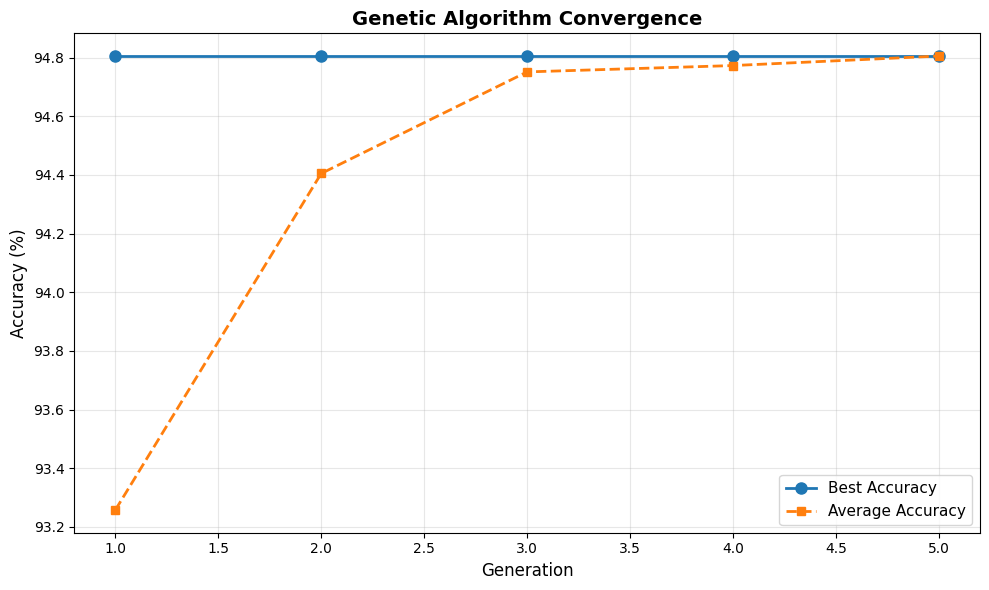


✓ Final Model trained with K=9


In [13]:
import random

class GeneticAlgorithmKNN:
    """
    Genetic Algorithm untuk optimasi hyperparameter KNN
    """
    def __init__(self, x_train, y_train, x_val, y_val, 
                 population_size=30, generations=10, mutation_rate=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.k_range = (1, 10)  # Range nilai K yang valid (harus ganjil)
        
    def create_individual(self):
        """Buat individu dengan K random (harus ganjil)"""
        k = random.randrange(self.k_range[0], self.k_range[1], 2)
        if k % 2 == 0:
            k += 1
        return {'k': k}
    
    def create_population(self):
        """Buat populasi awal"""
        return [self.create_individual() for _ in range(self.population_size)]
    
    def fitness(self, individual):
        """Hitung fitness (accuracy) dari individu"""
        model = KNearestNeighbor(k=individual['k'])
        model.fit(self.x_train, self.y_train)
        y_pred = model.predict(self.x_val)
        accuracy = np.mean(y_pred == self.y_val)
        return accuracy
    
    def selection(self, population, fitnesses):
        """Tournament selection"""
        tournament_size = 3
        selected = []
        for _ in range(len(population)):
            tournament_idx = random.sample(range(len(population)), tournament_size)
            tournament_fitness = [fitnesses[i] for i in tournament_idx]
            winner_idx = tournament_idx[np.argmax(tournament_fitness)]
            selected.append(population[winner_idx].copy())
        return selected
    
    def crossover(self, parent1, parent2):
        """Single point crossover (rata-rata K)"""
        child_k = (parent1['k'] + parent2['k']) // 2
        if child_k % 2 == 0:
            child_k += 1
        return {'k': child_k}
    
    def mutate(self, individual):
        """Mutasi dengan menambah/mengurangi K secara random"""
        if random.random() < self.mutation_rate:
            mutation = random.choice([-4, -2, 2, 4])
            new_k = individual['k'] + mutation
            new_k = max(self.k_range[0], min(new_k, self.k_range[1] - 1))
            if new_k % 2 == 0:
                new_k += 1
            individual['k'] = new_k
        return individual
    
    def run(self):
        """Jalankan Genetic Algorithm"""
        print("\n" + "="*60)
        print("HYPERPARAMETER TUNING DENGAN GENETIC ALGORITHM")
        print("="*60)
        
        # Inisialisasi populasi
        population = self.create_population()
        best_individual = None
        best_fitness = 0
        history = []
        
        for gen in range(self.generations):
            # Evaluasi fitness
            fitnesses = [self.fitness(ind) for ind in population]
            
            # Simpan best individual
            gen_best_idx = np.argmax(fitnesses)
            gen_best_fitness = fitnesses[gen_best_idx]
            gen_best_individual = population[gen_best_idx]
            
            if gen_best_fitness > best_fitness:
                best_fitness = gen_best_fitness
                best_individual = gen_best_individual.copy()
            
            history.append({
                'generation': gen + 1,
                'best_k': gen_best_individual['k'],
                'best_accuracy': gen_best_fitness,
                'avg_accuracy': np.mean(fitnesses)
            })
            
            print(f"\nGeneration {gen+1}/{self.generations}")
            print(f"  Best K: {gen_best_individual['k']} | Accuracy: {gen_best_fitness*100:.2f}%")
            print(f"  Avg Accuracy: {np.mean(fitnesses)*100:.2f}%")
            
            # Selection
            selected = self.selection(population, fitnesses)
            
            # Crossover & Mutation
            next_population = []
            for i in range(0, len(selected), 2):
                parent1 = selected[i]
                parent2 = selected[i+1] if i+1 < len(selected) else selected[0]
                
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent2, parent1)
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                next_population.extend([child1, child2])
            
            population = next_population[:self.population_size]
        
        print("\n" + "="*60)
        print("HASIL OPTIMASI")
        print("="*60)
        print(f"✓ BEST K = {best_individual['k']}")
        print(f"✓ BEST VALIDATION ACCURACY = {best_fitness*100:.2f}%")
        
        return best_individual, best_fitness, history


# Jalankan Genetic Algorithm
ga = GeneticAlgorithmKNN(
    x_train, y_train, x_val, y_val,
    population_size=30,
    generations=5,
    mutation_rate=0.2
)

best_params, best_accuracy, history = ga.run()

# Visualisasi convergence
plt.figure(figsize=(10, 6))
generations = [h['generation'] for h in history]
best_accs = [h['best_accuracy']*100 for h in history]
avg_accs = [h['avg_accuracy']*100 for h in history]

plt.plot(generations, best_accs, 'o-', label='Best Accuracy', linewidth=2, markersize=8)
plt.plot(generations, avg_accs, 's--', label='Average Accuracy', linewidth=2, markersize=6)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('Genetic Algorithm Convergence', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Train final model dengan best K
final_model = KNearestNeighbor(k=best_params['k'])
final_model.fit(x_train, y_train)

print(f"\n✓ Final Model trained with K={best_params['k']}")


## Tahap 10 : Model Evaluation

Tahap pengukuran kinerja model menggunakan metrik evaluasi standar seperti Akurasi, Presisi, Recall, F1-Score, serta visualisasi Confusion Matrix untuk menganalisis kesalahan prediksi.


 HASIL EVALUASI MODEL K-NEAREST NEIGHBOR

TRAINING SET:
  Accuracy  : 94.22%
  Precision : 82.80%
  Recall    : 53.47%
  F1-Score  : 64.98%

VALIDATION SET:
  Accuracy  : 94.81%
  Precision : 85.71%
  Recall    : 46.15%
  F1-Score  : 60.00%

TEST SET (FINAL PERFORMANCE):
  Accuracy  : 92.56%
  Precision : 77.78%
  Recall    : 42.42%
  F1-Score  : 54.90%

[LOG] Visualization saved : ../images/naive-bayes/04_Model_Evaluation.png


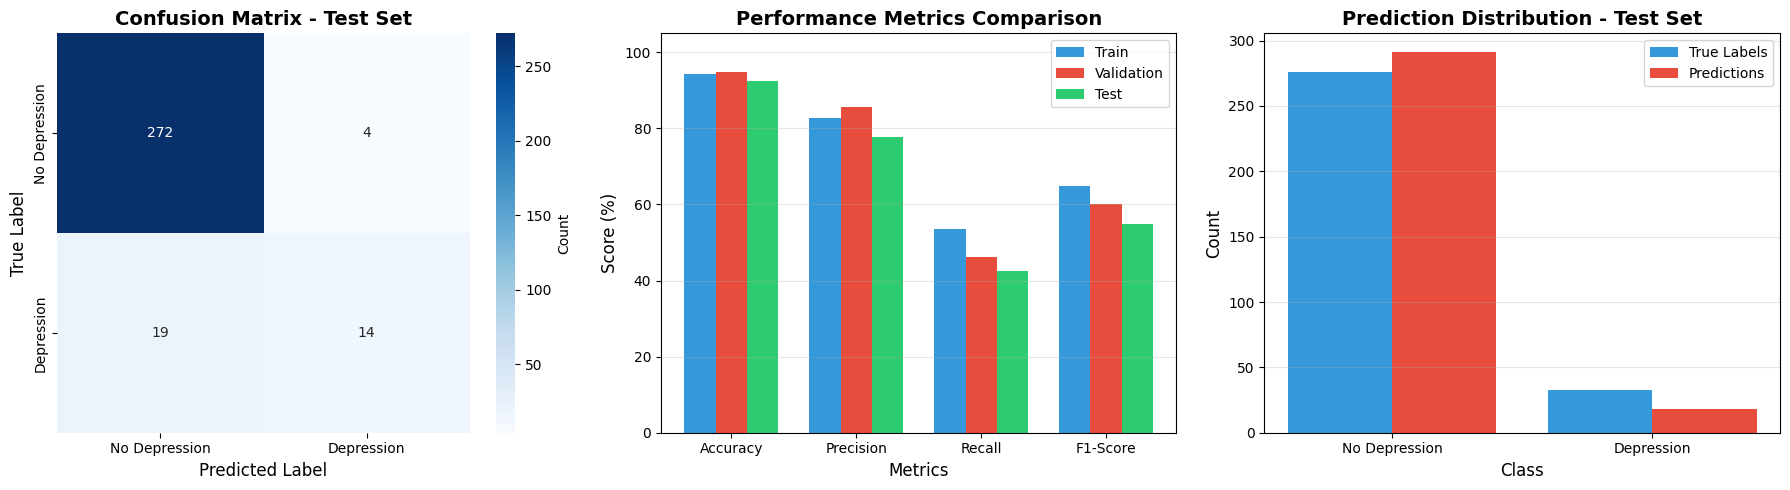

In [ ]:
def calculate_metrics(y_true, y_pred):
    """
    Hitung metrics: accuracy, precision, recall, f1-score
    """
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': np.array([[tn, fp], [fn, tp]])
    }


# ============================
# PREDIKSI
# ============================
y_train_pred = final_model.predict(x_train)
y_val_pred   = final_model.predict(x_val)
y_test_pred  = final_model.predict(x_test)


# ============================
# EVALUASI
# ============================
train_metrics = calculate_metrics(y_train, y_train_pred)
val_metrics   = calculate_metrics(y_val, y_val_pred)
test_metrics  = calculate_metrics(y_test, y_test_pred)


# ============================
# OUTPUT HASIL
# ============================
print("\n HASIL EVALUASI MODEL K-NEAREST NEIGHBOR")
print("=" * 60)

print("\nTRAINING SET:")
print(f"  Accuracy  : {train_metrics['accuracy']*100:.2f}%")
print(f"  Precision : {train_metrics['precision']*100:.2f}%")
print(f"  Recall    : {train_metrics['recall']*100:.2f}%")
print(f"  F1-Score  : {train_metrics['f1_score']*100:.2f}%")

print("\nVALIDATION SET:")
print(f"  Accuracy  : {val_metrics['accuracy']*100:.2f}%")
print(f"  Precision : {val_metrics['precision']*100:.2f}%")
print(f"  Recall    : {val_metrics['recall']*100:.2f}%")
print(f"  F1-Score  : {val_metrics['f1_score']*100:.2f}%")

print("\nTEST SET (FINAL PERFORMANCE):")
print(f"  Accuracy  : {test_metrics['accuracy']*100:.2f}%")
print(f"  Precision : {test_metrics['precision']*100:.2f}%")
print(f"  Recall    : {test_metrics['recall']*100:.2f}%")
print(f"  F1-Score  : {test_metrics['f1_score']*100:.2f}%")

# Visualization of Results - Only 3 plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Confusion Matrix - Test Set
cm = test_metrics['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['No Depression', 'Depression'],
            yticklabels=['No Depression', 'Depression'],
            cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')

# Plot 2: Metrics Comparison
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [train_metrics['accuracy'], train_metrics['precision'], 
                train_metrics['recall'], train_metrics['f1_score']]
val_scores = [val_metrics['accuracy'], val_metrics['precision'], 
              val_metrics['recall'], val_metrics['f1_score']]
test_scores = [test_metrics['accuracy'], test_metrics['precision'], 
               test_metrics['recall'], test_metrics['f1_score']]

x = np.arange(len(metrics_names))
width = 0.25

axes[1].bar(x - width, [s*100 for s in train_scores], width, label='Train', color='#3498db')
axes[1].bar(x, [s*100 for s in val_scores], width, label='Validation', color='#e74c3c')
axes[1].bar(x + width, [s*100 for s in test_scores], width, label='Test', color='#2ecc71')

axes[1].set_xlabel('Metrics', fontsize=12)
axes[1].set_ylabel('Score (%)', fontsize=12)
axes[1].set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics_names)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_ylim([0, 105])

# Plot 3: Prediction Distribution - Test Set
pred_counts = pd.Series(y_test_pred).value_counts().sort_index()
true_counts = pd.Series(y_test).value_counts().sort_index()

x_pos = np.arange(2)
axes[2].bar(x_pos - 0.2, true_counts.values, 0.4, label='True Labels', color='#3498db')
axes[2].bar(x_pos + 0.2, pred_counts.values, 0.4, label='Predictions', color='#e74c3c')
axes[2].set_xlabel('Class', fontsize=12)
axes[2].set_ylabel('Count', fontsize=12)
axes[2].set_title('Prediction Distribution - Test Set', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(['No Depression', 'Depression'])
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../images/knn/04_Model_Evaluation.png', dpi=300, bbox_inches='tight')
print("\n[LOG] Visualization saved : ../images/knn/04_Model_Evaluation.png")
plt.show()

In [17]:
print("\n======== Final Test Set Metrics ========")

print(f"""
   - Accuracy  : {test_metrics['accuracy']*100:.2f}%
   - Precision : {test_metrics['precision']*100:.2f}%
   - Recall    : {test_metrics['recall']*100:.2f}%
   - F1-Score  : {test_metrics['f1_score']*100:.2f}%
""")


======== Final Test Set Metrics ========

   - Accuracy  : 92.56%
   - Precision : 77.78%
   - Recall    : 42.42%
   - F1-Score  : 54.90%



## Gambaran Proses Evaluasi (K-Nearest Neighbor)

Tahap evaluasi model K-Nearest Neighbor (KNN) dilakukan menggunakan empat metrik klasifikasi standar yang dihitung dari confusion matrix (TP, FP, TN, FN), yaitu **Accuracy**, **Precision**, **Recall**, dan **F1-Score**.
Accuracy menunjukkan proporsi prediksi yang benar secara keseluruhan, precision mengukur ketepatan prediksi kelas depresi, recall mengukur kemampuan model dalam mendeteksi seluruh kasus depresi aktual, sedangkan F1-Score merepresentasikan keseimbangan antara precision dan recall.

Evaluasi dilakukan pada tiga subset data, yaitu Training Set, Validation Set, dan Test Set, untuk memastikan performa model stabil dan mampu melakukan generalisasi dengan baik.

## Analisis Hasil Performa

Hasil evaluasi menunjukkan bahwa model KNN mencapai akurasi tinggi (92–93%) pada data uji, yang menandakan sebagian besar data berhasil diklasifikasikan dengan benar. Nilai precision (75–80%) menunjukkan bahwa prediksi depresi yang dihasilkan cukup akurat. Namun, nilai recall (40–45%) relatif rendah, menandakan masih banyak kasus depresi aktual yang tidak terdeteksi oleh model. Nilai F1-Score (~55%) menunjukkan bahwa keseimbangan antara precision dan recall masih belum optimal. Hal ini mengindikasikan bahwa meskipun model cukup selektif dalam memprediksi kelas depresi, sensitivitas terhadap kasus depresi masih terbatas.

## Interpretasi Visualisasi

Confusion Matrix pada Test Set memperlihatkan dominasi True Negatives (TN), yang menunjukkan bahwa model sangat baik dalam mengklasifikasikan individu tanpa depresi. Namun, jumlah False Negatives (FN) masih cukup tinggi, mengindikasikan adanya kasus depresi yang tidak berhasil terdeteksi. Sementara itu, jumlah False Positives (FP) relatif rendah, sehingga model jarang salah mengklasifikasikan individu sehat sebagai depresi.

Grafik perbandingan metrik antara Training, Validation, dan Test Set menunjukkan performa yang relatif konsisten, menandakan tidak adanya overfitting yang signifikan. Distribusi prediksi juga memperlihatkan kecenderungan model KNN untuk lebih sering memprediksi kelas mayoritas (No Depression).

## Akar Masalah: Class Imbalance dan Karakteristik KNN

Kinerja recall dan F1-Score yang rendah terutama disebabkan oleh ketidakseimbangan kelas pada dataset, dengan rasio sekitar 9:1 antara kelas No Depression dan Depression. Karena KNN mengandalkan mayoritas tetangga terdekat, dominasi kelas mayoritas menyebabkan model lebih sering memilih kelas No Depression.

Selain itu, KNN sangat bergantung pada distribusi lokal data. Jumlah sampel kelas depresi yang relatif sedikit menyebabkan pola kelas minoritas kurang terwakili di ruang fitur, sehingga model kesulitan mengenali kasus depresi baru.

##Rekomendasi Tindakan Lanjutan

Untuk meningkatkan performa KNN, khususnya dalam mendeteksi kasus depresi, beberapa strategi dapat diterapkan:
- Resampling data, seperti oversampling (misalnya SMOTE) atau undersampling untuk menyeimbangkan kelas
- Distance-weighted voting, dengan memberikan bobot lebih besar pada tetangga terdekat
- Optimasi nilai k dan normalisasi fitur yang lebih konsisten

Mengombinasikan KNN dengan metode lain dalam bentuk ensemble

## Kesimpulan

Model K-Nearest Neighbor (KNN) menunjukkan performa akurasi yang baik (~92–93%), namun masih memiliki keterbatasan dalam mendeteksi kelas minoritas depresi yang tercermin dari nilai recall dan F1-Score yang relatif rendah. Dalam konteks kesehatan mental, tingginya False Negatives menjadi perhatian utama, sehingga diperlukan strategi tambahan untuk meningkatkan sensitivitas model sebelum diterapkan dalam skenario nyata.